In [16]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
#fonction qui import et concat les fichiers csv entre deux semaines

def extract(data_dir : str, prefix : str, start_week : int, end_week:int) -> pd.DataFrame:
    df = pd.DataFrame()
    for i in range(start_week, end_week+1):
        file_path = os.path.join(data_dir, "batchs",f'{prefix}_week_{i}.csv')
        if os.path.isfile(file_path):
            batch = pd.read_csv(file_path)
            df = pd.concat([df,batch], sort=True)
    return df

In [3]:
def clean1(df):
    df.columns = df.columns.str.lower().str.replace(' ','_')
    df['ca'] = df['product_price'] * df['quantity']
    df['cash_in'] = df.groupby(['order_number'])['ca'].transform(np.sum)
    df = df.drop(columns= ['item_name','quantity','product_price','total_products','ca'])
    df = df.reset_index(drop =True)
    df = df.drop_duplicates()
    return df

In [4]:
def clean2(df):
    df.columns = df.columns.str.lower().str.replace(' ','_')
    df['ca'] = df['product_price'] * df['quantity']
    df['cash_in'] = df.groupby(['order_id'])['ca'].transform(np.sum)
    df = df.drop(columns= ['item_name','quantity','product_price','total_products','ca'])
    df = df.reset_index(drop =True)
    df = df.drop_duplicates()
    return df

In [5]:
def merge(df1,df2):
    df2.columns = ['order_date','order_number','cash_in']
    df = pd.concat([df1,df2], sort=True)
    df = df.drop(columns='order_number')
    df = df.sort_values('order_date')
    return df

In [6]:
def etl(data_dir : str, start_week : int, end_week:int) -> pd.DataFrame:
    df1 = extract(data_dir,"restaurant_1",start_week,end_week)
    df2 = extract(data_dir,"restaurant_2",start_week,end_week)
    df1 = clean1(df1)
    df2 = clean2(df2)
    df = merge(df1,df2)
    df['order_date'] = pd.to_datetime(df['order_date'])
    df = df.resample('1H', on='order_date').sum().reset_index()
    return df

In [89]:
df = etl("C:/Users/159072/EXOML",120,150)

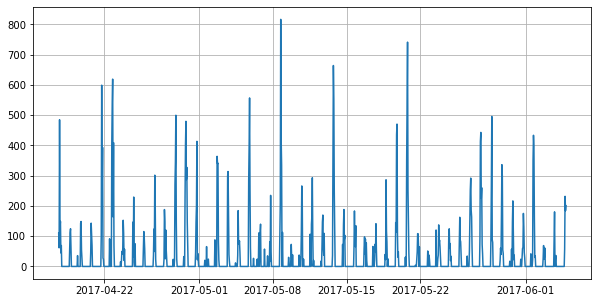

In [11]:
fig = plt.figure(figsize =(10,5))
plt.plot(df['order_date'],df['cash_in'])
plt.grid(True)

In [66]:
df

,order_date,cash_in
0,2017-04-17 16:00:00,109.60
1,2017-04-17 17:00:00,61.55
2,2017-04-17 18:00:00,484.95
3,2017-04-17 19:00:00,129.45
4,2017-04-17 20:00:00,148.85
...,...,...
5185,2017-11-19 17:00:00,113.80
5186,2017-11-19 18:00:00,258.80
5187,2017-11-19 19:00:00,104.95
5188,2017-11-19 20:00:00,0.00


### Modélisation

In [101]:
# création de nouvelles variables à partir de la date 
def ajout_var(df) -> pd.DataFrame:
    df['month'] = pd.DatetimeIndex(df['order_date']).month
    df['hour'] = pd.DatetimeIndex(df['order_date']).hour
    df['weekday'] = (pd.DatetimeIndex(df['order_date']).weekday)+1 # lundi = 1
    df['lag'] = df['cash_in'].shift(168) #avoir le CA d'il y a une semaine à la même heure
    df = df.dropna()
    df = pd.get_dummies(df, columns=['month','hour','weekday'])
    df = df.reset_index()
    return df

In [102]:
df_dum = ajout_var(df)

In [104]:
df_dum

,index,order_date,cash_in,lag,month_4,month_5,month_6,month_7,month_8,month_9,...,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,168,2017-04-24 16:00:00,0.00,109.60,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,169,2017-04-24 17:00:00,146.55,61.55,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,170,2017-04-24 18:00:00,31.95,484.95,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,171,2017-04-24 19:00:00,229.45,129.45,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,172,2017-04-24 20:00:00,14.50,148.85,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5017,5185,2017-11-19 17:00:00,113.80,106.55,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5018,5186,2017-11-19 18:00:00,258.80,108.10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5019,5187,2017-11-19 19:00:00,104.95,141.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5020,5188,2017-11-19 20:00:00,0.00,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
#création echantillons train et test
X = df.cash_in
Y = df[['month','hour','weekday','lag']]

a = len(Y)*0.8
y_train = Y[,]

InvalidIndexError: (slice(1, 4152.0, None),)